In [1]:
from collections import deque

import gym
import imageio
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.distributions import Categorical 

In [2]:
class ActorCriticNet(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()
        h = 64
        self.head = nn.Sequential(
            nn.Linear(obs_space, h),
            nn.Tanh()
        )
        self.pol = nn.Sequential(
            nn.Linear(h, h),
            nn.Tanh(),
            nn.Linear(h, action_space)
        )
        self.val = nn.Sequential(
            nn.Linear(h, h),
            nn.Tanh(),
            nn.Linear(h, 1)
        )
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        out = self.head(x)
        logit = self.pol(out).reshape(out.shape[0], -1)
        log_p = self.log_softmax(logit)
        v = self.val(out).reshape(out.shape[0], 1)

        return log_p, v

In [3]:
def get_action_and_value(obs, old_net):
    old_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p, v = old_net(state)
        m = Categorical(log_p.exp())
        action = m.sample()

    return action.item(), v.item()

## Main

In [4]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('MountainCar-v0')
env = gym.make('LunarLander-v2')

SEED = 0
env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 1000
n_eval = env.spec.trials

# global values
total_steps = 0
rewards = []
reward_eval = deque(maxlen=n_eval)
is_solved = False

# load a model
target_net = ActorCriticNet(obs_space, action_space).to(device)
target_net.load_state_dict(torch.load(
    './saved_models/LunarLander-v2_ep5416_clear_model_ppo_st.pt'))

/home/jay/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [5]:
env.spec.max_episode_steps

1000

In [6]:
env.spec.trials

100

In [7]:
env.spec.reward_threshold

200

In [8]:
# env.metadata['video.frames_per_second'] = 60

In [9]:
# play
# frames = []
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         frames.append(env.render(mode = 'rgb_array'))
        env.render()
        action, _ = get_action_and_value(obs, target_net)
        _obs, reward, done, _ = env.step(action)
        obs = _obs
        total_steps += 1
        ep_reward += reward     
    if done:
        env.render()
        rewards.append(ep_reward)
        reward_eval.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, total_steps, ep_reward))
#         frames.append(env.render(mode = 'rgb_array'))
#         imageio.mimsave(f'{env.spec.id}.gif', frames,)
        
        if len(reward_eval) >= n_eval:
            if np.mean(reward_eval) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, total_steps))
                print(np.mean(reward_eval))
                break
env.close()

  1 Episode in   731 steps, reward 123.52
  2 Episode in  1194 steps, reward 227.86
  3 Episode in  1637 steps, reward 232.68
  4 Episode in  2025 steps, reward 263.44
  5 Episode in  2511 steps, reward 211.97
  6 Episode in  2972 steps, reward 230.48
  7 Episode in  3437 steps, reward 227.57
  8 Episode in  3877 steps, reward 237.61
  9 Episode in  4382 steps, reward 207.09
 10 Episode in  4983 steps, reward 224.19
 11 Episode in  5479 steps, reward 256.35
 12 Episode in  6253 steps, reward 222.22
 13 Episode in  6807 steps, reward 184.00
 14 Episode in  7336 steps, reward 235.48
 15 Episode in  8336 steps, reward 105.12
 16 Episode in  8730 steps, reward 228.88
 17 Episode in  9225 steps, reward 177.57
 18 Episode in  9717 steps, reward 231.36
 19 Episode in 10178 steps, reward 235.16
 20 Episode in 10637 steps, reward 250.57
 21 Episode in 11101 steps, reward 212.41
 22 Episode in 11665 steps, reward 189.28
 23 Episode in 12128 steps, reward 177.54
 24 Episode in 12609 steps, reward

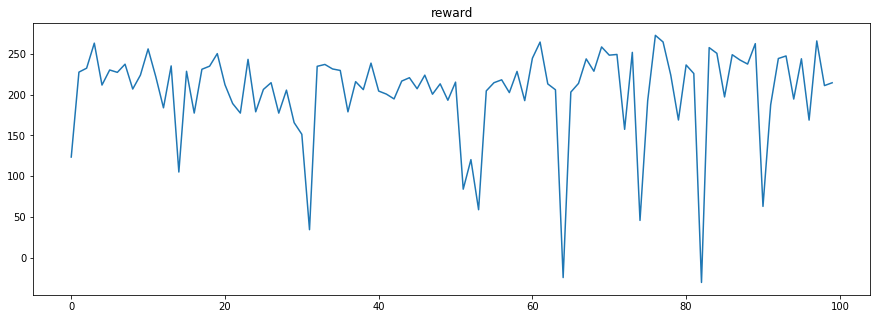

In [10]:
plt.figure(figsize=(15, 5))
plt.title('reward')
plt.plot(rewards)
plt.show()

In [11]:
[
    ('CartPole-v0', 412, 1),
    ('CartPole-v1', 452, 0.05),
    ('MountainCar-v0', 193, 0.1),
    ('LunarLander-v2', 260, 0.1)
]

[('CartPole-v0', 412, 1),
 ('CartPole-v1', 452, 0.05),
 ('MountainCar-v0', 193, 0.1),
 ('LunarLander-v2', 260, 0.1)]